In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from salishsea_tools import viz_tools, places, visualisations
from matplotlib import pyplot as plt, dates
from datetime import datetime, timedelta
from calendar import month_name
from scipy.io import loadmat
from tqdm.notebook import tqdm
from salishsea_tools import nc_tools
from dask.diagnostics import ProgressBar
import cmocean
from scipy.stats import sem
import arrow
%matplotlib inline

In [2]:
plt.rcParams.update({'font.size': 12, 'axes.titlesize': 'medium'})

##### Load files from monthly averages

In [3]:
# Load monthly averages
monthly_array_halocline_depth_SSslice = np.zeros([16,3,898,398])
monthly_array_halocline_strength_SSslice = np.zeros([16,3,898,398])

mask = xr.open_dataset('/ocean/ksuchy/MOAD/NEMO-forcing/grid/mesh_mask202108.nc')
slc = {'y': slice(0,898), 'x': slice(0,398)} 
e3t, tmask,depth = [mask[var].isel(**slc).values for var in ('e3t_0', 'tmask','gdept_0')]
years, variables = range(2007, 2022), ['halocline','strength']


# Haloorary list dict
data = {}

# Permanent aggregate dict
aggregates = {var: {} for var in variables}

slc = {'gridY': slice(0,898), 'gridX': slice(0,398)} #redefine with gridY and gridX for biol dataset because there are new coordinate names for 202111 model run

# Loop through years
for year in years:
    mar = arrow.get(f"{year}-03-01")
    may = arrow.get(f"{year}-05-01")
    
    for var in variables: 
        data[var] = []
    # Load monthly averages 
    months = arrow.Arrow.range("month", mar, may)
    for month in months:
        yyyymmdd_first = month.format("YYYYMMDD")
        yyyymmdd_last = month.shift(months=+1).shift(days=-1).format("YYYYMMDD")
        ds_file = f"/results2/SalishSea/month-avg.202111/SalishSeaCast_1m_grid_T_{yyyymmdd_first}_{yyyymmdd_last}.nc"
   
        
    
        
        # Load grazing variables
        with xr.open_dataset(ds_file) as ds:
            for var in ['halocline','strength']:
                sal=ds.vosaline.isel(**slc).values
                      
                 #get the gradient in salinity
                sal_grad = np.zeros_like(sal)

                for i in range(0, (np.shape(sal_grad)[1]-1)):
                    sal_grad[:,i,:,:] =(sal[:,i,:,:]-sal[:,i+1,:,:])/(depth[:,i,:,:]-depth[:,i+1,:,:])

                #print(sal_grad)

                loc_max = np.argmax(sal_grad,axis=1)
                depths=np.tile(depth,[np.shape(sal)[0],1,1,1])
                h1=np.take_along_axis(depths, np.expand_dims(loc_max, axis=1), axis=1)
                h2=np.take_along_axis(depths, np.expand_dims(loc_max+1, axis=1), axis=1)
            
                sals=np.tile(sal,[np.shape(sal)[0],1,1,1])
                s1=np.take_along_axis(sals, np.expand_dims(loc_max, axis=1), axis=1)
                s2=np.take_along_axis(sals, np.expand_dims(loc_max+1, axis=1), axis=1)

                #halocline is halfway between the two cells
                halocline = 0.5*(h1+h2)
                strength = (s2-s1)/(h2-h1)
        
                data['halocline'].append(halocline)
                data['strength'].append(strength)
                        
            monthly_array_halocline_depth_SSslice[year-2022,month.month-3,:,:]=halocline
            monthly_array_halocline_strength_SSslice[year-2022,month.month-3,:,:]=strength #month-12
            
    # Concatenate months
        for var in variables: aggregates[var][year] = np.concatenate(data[var]).mean(axis=0)

# Calculate climatological mean and anomalies
for var in variables:
    aggregates[var]['mean'] = np.concatenate([aggregates[var][year][None, ...] for year in years]).mean(axis=0)
    for year in years: aggregates[var][year] = aggregates[var][year] - aggregates[var]['mean']

In [4]:
print(np.shape(aggregates['strength'][2017][0]))

(898, 398)


In [5]:
# Reset variables for plotting
tmask = tmask[0,0,...]
variables = ['halocline','strength']

In [6]:
print(np.shape(data['strength'][0][0][0]))

(898, 398)


In [7]:
aggregates['strength'][2017][0]

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

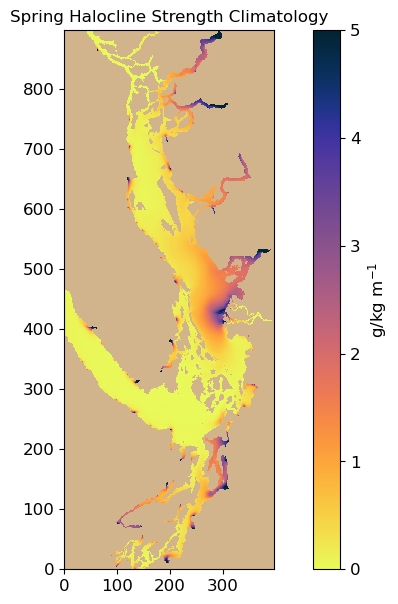

In [8]:
##### with pcolormesh: no smoothing
cmap0=cmocean.cm.balance
cmap0.set_bad('tan')
vmin=0
vmax=5
cmap1=cmocean.cm.thermal_r
cmap1.set_bad('tan')
il=0

fig,ax=plt.subplots(1,1,figsize=(10,7))
#fig.suptitle('Annual Anomalies Mesozoop Feeding on Diatoms', fontsize=16)
m0=ax.pcolormesh(np.ma.masked_where(tmask==0,((aggregates['strength']['mean'][0]))),cmap=cmap1,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax,coords='grid')
ax.set_title('Spring Halocline Strength Climatology')
fig.colorbar(m0,ax=ax,label='g/kg m$^{-1}$')


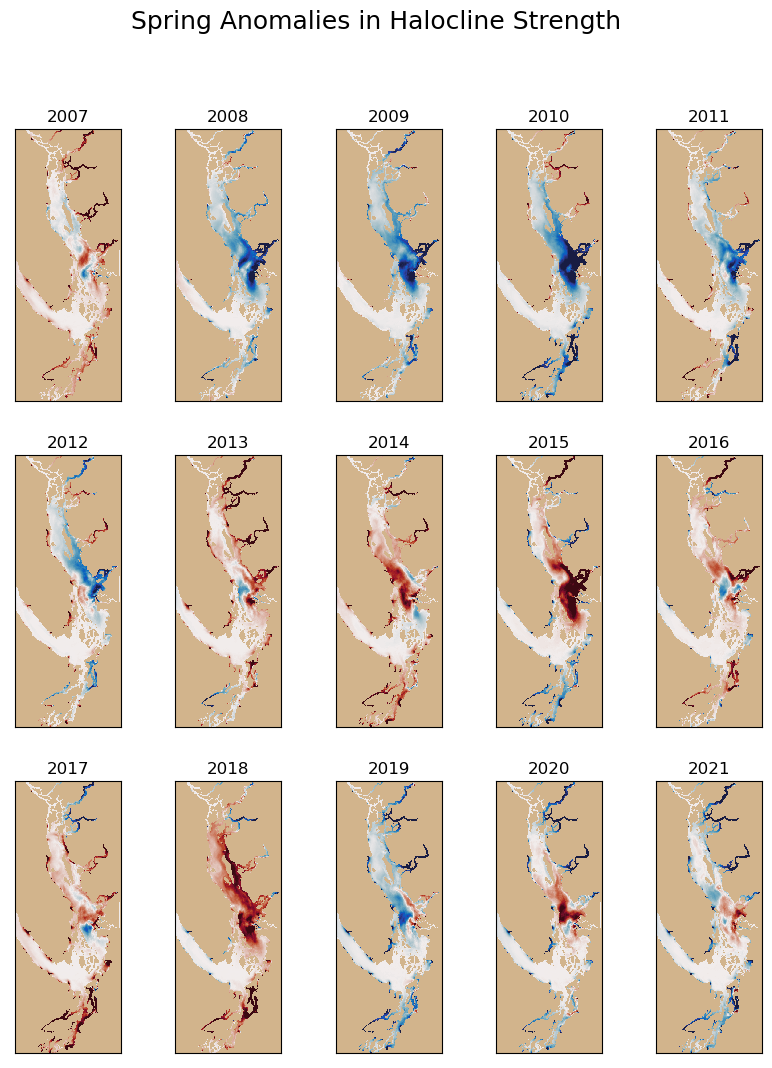

In [10]:
##### with pcolormesh: no smoothing
cmap0=cmocean.cm.balance
cmap0.set_bad('tan')

#cmap1=cmocean.cm.haline
#cmap1.set_bad('k')
il=0
vmin=-.5
vmax=.5

fig,ax=plt.subplots(3,5,figsize=(10,12))
fig.suptitle('Spring Anomalies in Halocline Strength', fontsize=18)


m0=ax[0,0].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['strength'][2007][0]))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[0,0],coords='grid')
ax[0,0].set_title('2007')
ax[0,0].yaxis.set_visible(False)
ax[0,0].xaxis.set_visible(False)
ax[0,0].yaxis.set_visible(False)
#fig.colorbar(m0,ax=ax[1])

m0=ax[0,1].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['strength'][2008][0]))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[0,1],coords='grid')
ax[0,1].set_title('2008')
ax[0,1].yaxis.set_visible(False)
ax[0,1].xaxis.set_visible(False)
ax[0,1].yaxis.set_visible(False)
#fig.colorbar(m0,ax=ax[2])

m0=ax[0,2].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['strength'][2009][0]))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[0,2],coords='grid')
ax[0,2].set_title('2009')
ax[0,2].yaxis.set_visible(False)
ax[0,2].xaxis.set_visible(False)
ax[0,2].yaxis.set_visible(False)
#fig.colorbar(m0,ax=ax[3])

m0=ax[0,3].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['strength'][2010][0]))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[0,3],coords='grid')
ax[0,3].set_title('2010')
ax[0,3].yaxis.set_visible(False)
ax[0,3].xaxis.set_visible(False)
ax[0,3].yaxis.set_visible(False)
#fig.colorbar(m0,ax=ax[4])

m0=ax[0,4].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['strength'][2011][0]))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[0,4],coords='grid')
ax[0,4].set_title('2011')
ax[0,4].yaxis.set_visible(False)
ax[0,4].xaxis.set_visible(False)
ax[0,4].yaxis.set_visible(False)
#fig.colorbar(m0,ax=ax[4])

### Second Row

m0=ax[1,0].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['strength'][2012][0]))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[1,0],coords='grid')
ax[1,0].set_title('2012')
ax[1,0].yaxis.set_visible(False)
ax[1,0].xaxis.set_visible(False)
ax[1,0].yaxis.set_visible(False)
#fig.colorbar(m0,ax=ax[1])

m0=ax[1,1].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['strength'][2013][0]))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[1,1],coords='grid')
ax[1,1].set_title('2013')
ax[1,1].yaxis.set_visible(False)
ax[1,1].xaxis.set_visible(False)
ax[1,1].yaxis.set_visible(False)
#fig.colorbar(m0,ax=ax[2])

m0=ax[1,2].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['strength'][2014][0]))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[1,2],coords='grid')
ax[1,2].set_title('2014')
ax[1,2].yaxis.set_visible(False)
ax[1,2].xaxis.set_visible(False)
ax[1,2].yaxis.set_visible(False)
#fig.colorbar(m0,ax=ax[3])

m0=ax[1,3].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['strength'][2015][0]))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[1,3],coords='grid')
ax[1,3].set_title('2015')
ax[1,3].yaxis.set_visible(False)
ax[1,3].xaxis.set_visible(False)
ax[1,3].yaxis.set_visible(False)
#fig.colorbar(m0,ax=ax[4])

m0=ax[1,4].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['strength'][2016][0]))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[1,4],coords='grid')
ax[1,4].set_title('2016')
ax[1,4].yaxis.set_visible(False)
ax[1,4].xaxis.set_visible(False)
ax[1,4].yaxis.set_visible(False)
#fig.colorbar(m0,ax=ax[4])


### Third Row

m0=ax[2,0].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['strength'][2017][0]))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[2,0],coords='grid')
ax[2,0].set_title('2017')
ax[2,0].yaxis.set_visible(False)
ax[2,0].xaxis.set_visible(False)
ax[2,0].yaxis.set_visible(False)
#fig.colorbar(m0,ax=ax[1])

m0=ax[2,1].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['strength'][2018][0]))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[2,1],coords='grid')
ax[2,1].set_title('2018')
ax[2,1].yaxis.set_visible(False)
ax[2,1].xaxis.set_visible(False)
ax[2,1].yaxis.set_visible(False)
#fig.colorbar(m0,ax=ax[2])

m0=ax[2,2].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['strength'][2019][0]))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[2,2],coords='grid')
ax[2,2].set_title('2019')
ax[2,2].yaxis.set_visible(False)
ax[2,2].xaxis.set_visible(False)
ax[2,2].yaxis.set_visible(False)
#fig.colorbar(m0,ax=ax[3])

m0=ax[2,3].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['strength'][2020][0]))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[2,3],coords='grid')
ax[2,3].set_title('2020')
ax[2,3].yaxis.set_visible(False)
ax[2,3].xaxis.set_visible(False)
ax[2,3].yaxis.set_visible(False)
#fig.colorbar(m0,ax=ax[4])

m0=ax[2,4].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['strength'][2021][0]))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[2,4],coords='grid')
ax[2,4].set_title('2021')
ax[2,4].yaxis.set_visible(False)
ax[2,4].xaxis.set_visible(False)
ax[2,4].yaxis.set_visible(False)
#fig.colorbar(m0,ax=ax[4])